In [1]:
%matplotlib inline

"""This version of the file is just for cooking up new ideas. gan_skip.ipynb is the master file."""

import os
# running with non gpu singularity container, so commented out the next line to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
tf.set_random_seed(42)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print "import tensorflow"
           
import keras.backend.tensorflow_backend as K

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Lambda
from keras.layers import Input, merge, Concatenate, concatenate, Add
from keras.losses import binary_crossentropy
from keras.utils import plot_model
print "import keras"

import numpy as np
#from tqdm import tqdm
import time
import pickle
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print "import matplotlib"

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import binned_statistic_2d

print "import sklearn"

np.random.seed(42)


import tensorflow
import keras
import matplotlib


Using TensorFlow backend.


import sklearn


In [2]:
def Minv(cols,ptetaphi=False,nopy2=False):
    """
    Computes M for two objects given the cartesian momentum projections
    if `ptetaphi` is True, then assumes the 8 input columns are cylindrical eptetaphi
    if `nopy2` is True, input is 7 columns with no py2
    """
    if ptetaphi:
        cols = ptetaphi_to_cartesian(cols)
    if nopy2:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]          )**2
        M2 -= (cols[:,3]+cols[:,6])**2
    else:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]+cols[:,6])**2
        M2 -= (cols[:,3]+cols[:,7])**2
    return np.sqrt(M2)

def cartesian_to_ptetaphi(eight_cartesian_cols):
    """
    Takes 8 columns as cartesian e px py pz e px py pz
    and converts to e pt eta phi e pt eta phi
    """
    e1 =  eight_cartesian_cols[:,0]
    e2 =  eight_cartesian_cols[:,4]
    px1 = eight_cartesian_cols[:,1]
    px2 = eight_cartesian_cols[:,5]
    py1 = eight_cartesian_cols[:,2]
    py2 = eight_cartesian_cols[:,6]
    pz1 = eight_cartesian_cols[:,3]
    pz2 = eight_cartesian_cols[:,7]
    p1 = np.sqrt(px1**2+py1**2+pz1**2)
    p2 = np.sqrt(px2**2+py2**2+pz2**2)
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    eta1 = np.arctanh(pz1/p1)
    eta2 = np.arctanh(pz2/p2)
    return np.c_[e1,pt1,eta1,phi1,e2,pt2,eta2,phi2]

def ptetaphi_to_cartesian(eight_eptetaphi_cols):
    """
    Takes 8 columns as e pt eta phi e pt eta phi
    and converts to e px py pz e px py pz
    """
    e1 =  eight_eptetaphi_cols[:,0]
    e2 =  eight_eptetaphi_cols[:,4]
    pt1 =  eight_eptetaphi_cols[:,1]
    pt2 =  eight_eptetaphi_cols[:,5]
    eta1 =  eight_eptetaphi_cols[:,2]
    eta2 =  eight_eptetaphi_cols[:,6]
    phi1 =  eight_eptetaphi_cols[:,3]
    phi2 =  eight_eptetaphi_cols[:,7]
    px1 = np.abs(pt1)*np.cos(phi1)
    px2 = np.abs(pt2)*np.cos(phi2)
    py1 = np.abs(pt1)*np.sin(phi1)
    py2 = np.abs(pt2)*np.sin(phi2)
    pz1 = np.abs(pt1)/np.tan(2.0*np.arctan(np.exp(-1.*eta1)))
    pz2 = np.abs(pt2)/np.tan(2.0*np.arctan(np.exp(-1.*eta2)))
    return np.c_[e1,px1,py1,pz1,e2,px2,py2,pz2]

def get_dphi(px1,py1,px2,py2):
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi 
    return dphi

def get_rotated_pxpy(px1,py1,px2,py2):
    """
    rotates two leptons such that phi2 = 0
    """
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    px1p = pt1*np.cos(phi1-phi2)
    py1p = pt1*np.sin(phi1-phi2)
    px2p = pt2*np.cos(phi2-phi2)
    return px1p,py1p,px2p,np.zeros(len(pt2))
    
def cartesian_zerophi2(coords,ptetaphi=False):
    """
    returns 8-1=7 columns rotating leptons such that phi2 is 0 (and removing it)
    if `ptetaphi` is True, then return eptetaphi instead of epxpypz
    """
    lepcoords_cyl = cartesian_to_ptetaphi(coords)
    phi1 = lepcoords_cyl[:,3]
    phi2 = lepcoords_cyl[:,7]
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi
    lepcoords_cyl[:,3] = dphi
    lepcoords_cyl[:,7] = 0.
    if ptetaphi:
        return np.delete(lepcoords_cyl, [7], axis=1)
    else:
        return np.delete(ptetaphi_to_cartesian(lepcoords_cyl), [6], axis=1)
    
    

In [3]:
def invmass_from_8cartesian(x):
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]+x[:,6:7])**2-
                (x[:,3:4]+x[:,7:8])**2
                )
    return invmass

def invmass_from_8cartesian_nopy2(x):
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]         )**2-
                (x[:,3:4]+x[:,6:7])**2
                )
    return invmass

def get_first_N(x,N=19):
    return x[:,0:N]

def add_invmass_from_8cartesian(x):
    return K.concatenate([x,invmass_from_8cartesian(x)])


def fix_outputs(x):
    """
    Take nominal delphes format of 19 columns and fix some columns
    """
    return K.concatenate([
        # x[:,0:21],
        x[:,0:7], # epxpypz for lep1,lep2 -1 for no py2
        x[:,7:8], # nvtx
        K.sign(x[:,8:10]), # q1 q2
        x[:,10:12], # iso1 iso2
        x[:,12:14], # met, metphi
        x[:,14:19], # jet pts
        ])

def custom_loss(c, loss_type = "force_mll"):
    if loss_type == "force_mll":
        def loss_func(y_true, y_pred_mll):
            y_true = y_true[:,0]
            y_pred = y_pred_mll[:,0]
            mll_pred = y_pred_mll[:,1]

            mll_loss = K.mean(K.abs(mll_pred - 91.2))

    #         pseudomll = K.random_normal_variable(shape=(1,1), mean=91.2, scale=2)
    #         mll_loss = K.mean((mll_pred - pseudomll)**2)

            return binary_crossentropy(y_true, y_pred) + c*mll_loss
        return loss_func
    elif loss_type == "force_z_width":
        def loss_func(y_true, y_pred_mll):
            y_true = y_true[:,0]
            y_pred = y_pred_mll[:,0]
            mll_pred = y_pred_mll[:,1]
            
            mll_loss = K.mean(K.abs(mll_pred - 91.2))
            mll_sigma_loss = K.abs(K.std(mll_pred) - 7.67)

            return binary_crossentropy(y_true, y_pred) + c*mll_loss + c*mll_sigma_loss
        return loss_func
        
    else:
        raise ValueError("Can not make loss function of type %s" % loss_type)
        
        
        

In [4]:
def METPhiMap(metphis):
    """Works so long as the tails are constrained within [-2pi, 2pi], maps everything from [-pi,pi]"""
    return ((metphis+np.pi) % (2*np.pi)) - np.pi

def M4(E,px,py,pz):
    """Takes in 4 vector components in cartesian and outputs minkowski scalar invariant"""
    return np.sqrt(E*E - px*px - py*py - pz*pz)

def make_plots_new(preds,reals,title="",fname="",show_data=True,show_pred=True,scaled=False,wspace=0.1,hspace=0.3,tightlayout=True,visible=False):
    nrows, ncols = 5,5
    fig, axs = plt.subplots(nrows,ncols,figsize=(16,13))
#     fig, axs = plt.subplots(nrows,ncols,figsize=(12,10))
#     fig.subplots_adjust(wspace=0.1,hspace=0.3)
    fig.subplots_adjust(wspace=wspace,hspace=hspace)

    if scaled:
        info = [
            ["lep1_e",(-1,1,100)],
            ["lep1_px",(-1,1,100)],
            ["lep1_py",(-1,1,100)],
            ["lep1_pz",(-1,1,100)],
            ["lep2_e",(-1,1,100)],
            ["lep2_px",(-1,1,100)],
            ["lep2_pz",(-1,1,100)],
            ["dphi",(-1,1,100)],
            ["nvtxs",(-1,1,100)],
            ["met",(-1,1,100)],
            ["metphi",(-1,1,100)],
            ["lep1_charge",(-1,1,100)],
            ["lep2_charge",(-1,1,100)],
            ["lep1_iso",(-1,1,100)],
            ["lep2_iso",(-1,1,100)],
            ["jet_pt1",(-1,1,100)],
            ["jet_pt2",(-1,1,100)],
            ["jet_pt3",(-1,1,100)],
            ["jet_pt4",(-1,1,100)],
            ["jet_pt5",(-1,1,100)],
            ["mll",(-1,1,100)],
            ["lep1_mass",(-1,1,100)],
            ["lep2_mass",(-1,1,100)],
            ["njets",(-1,1,100)],
            ["nvtx_MET",(-1,1,100)]

        ]
    else:
        info = [
            ["lep1_e",(0,250,50)],
            ["lep1_px",(-100,100,50)],
            ["lep1_py",(-100,100,50)],
            ["lep1_pz",(-200,200,50)],
            ["lep2_e",(0,250,50)],
            ["lep2_px",(-100,100,50)],
            ["lep2_pz",(-200,200,50)],
            ["dphi",(-4,4,50)],
            ["nvtxs",(0,50,350)],
            ["met",(0,150,50)],
            ["metphi",(-6,6,50)],
            ["lep1_charge",(-7,7,30)],
            ["lep2_charge",(-7,7,30)],
            ["lep1_iso",(0,2.0,30)],
            ["lep2_iso",(0,2.0,30)],
            ["jet_pt1",(0,100,50)],
            ["jet_pt2",(0,100,50)],
            ["jet_pt3",(0,100,50)],
            ["jet_pt4",(0,100,50)],
            ["jet_pt5",(0,100,50)],
            ["mll",(60,120,50)],
            ["lep1_mass",(0,100,50)],
            ["lep2_mass",(0,100,50)],
            ["njets",(0,7,7)],
            ["nvtx_MET",(0,50,50)]

        ]
    for axx in axs:
        for ax in axx:
            ax.get_yaxis().set_visible(False)
    for ic,(cname,crange) in enumerate(info):
        idx = ic // ncols, ic % ncols
        if cname == "nvtx_MET":
            if show_data:
                axs[idx].scatter(reals["nvtxs"], reals["met"])
            if show_pred:
                axs[idx].scatter(np.round(preds[:,7]), preds[:,12])
            axs[idx].set_xlabel("{}".format("Num Verticies Vs. MET"))
            axs[idx].get_yaxis().set_visible(False)
            plt.xlim(crange[0],crange[1])
        else:
            if cname == "mll":
                real = reals["mll"]
                pred = Minv(preds,ptetaphi=False,nopy2=True)
            elif cname == "lep1_mass": real, pred = M4(reals["lep1_e"], reals["lep1_px"], reals["lep1_py"], reals["lep1_pz"]), M4(preds[:,0], preds[:,1], preds[:,2], preds[:,3])
            elif cname == "lep2_mass": real, pred = M4(reals["lep2_e"], reals["lep2_px"], 0, reals["lep2_pz"]), M4(preds[:,4], preds[:,5], preds[:,6], preds[:,7])
            elif cname == "lep1_e": real, pred = reals[cname], preds[:,0]
            elif cname == "lep1_pz": real, pred = reals[cname], preds[:,3]
            elif cname == "lep2_e": real, pred = reals[cname], preds[:,4]
            elif cname == "lep2_pz": real, pred = reals[cname], preds[:,6]
            elif cname == "lep1_px": 
                real = reals[cname]
                pred = preds[:,1]
            elif cname == "lep1_py":
                real = reals[cname]
                pred = preds[:,2]
            elif cname == "lep2_px":
                real = reals[cname]
                pred = preds[:,5]
            elif cname == "dphi":
                real = get_dphi(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], np.zeros(len(reals)))
                pred = get_dphi(preds[:,1], preds[:,2], preds[:,5], np.zeros(len(preds)))
            elif cname == "nvtxs": real, pred = reals[cname], np.round(preds[:,7])
            elif cname == "lep1_charge": real, pred = reals[cname], preds[:,8]
            elif cname == "lep2_charge": real, pred = reals[cname], preds[:,9]
            elif cname == "lep1_iso": real, pred = reals[cname], preds[:,10]
            elif cname == "lep2_iso": real, pred = reals[cname], preds[:,11]
            elif cname == "met": real, pred = reals[cname], preds[:,12]
            elif cname == "metphi": real, pred = reals[cname], METPhiMap(preds[:,13])
            elif cname == "jet_pt1": real, pred = reals[cname], preds[:,14]
            elif cname == "jet_pt2": real, pred = reals[cname], preds[:,15]
            elif cname == "jet_pt3": real, pred = reals[cname], preds[:,16]
            elif cname == "jet_pt4": real, pred = reals[cname], preds[:,17]
            elif cname == "jet_pt5": real, pred = reals[cname], preds[:,18]
            elif cname == "njets":
                real = \
                    1*(reals["jet_pt1"] > 10) + \
                    1*(reals["jet_pt2"] > 10) + \
                    1*(reals["jet_pt3"] > 10) + \
                    1*(reals["jet_pt4"] > 10) + \
                    1*(reals["jet_pt5"] > 10)
                pred = \
                    1*(preds[:,14] > 10) + \
                    1*(preds[:,15] > 10) + \
                    1*(preds[:,16] > 10) + \
                    1*(preds[:,17] > 10) + \
                    1*(preds[:,18] > 10)
            if show_data:
                bins_real = axs[idx].hist(real, range=crange[:2],bins=crange[-1], histtype="step", lw=1.5,density=True)
            if show_pred:
                bins_pred = axs[idx].hist(pred, range=crange[:2],bins=crange[-1], histtype="step", lw=1.5,density=True)
            axs[idx].set_xlabel("{}".format(cname))
            axs[idx].get_yaxis().set_visible(False)
        #     axs[idx].set_yscale("log", nonposy='clip')
    _ = axs[0,0].legend(["True","Pred"], loc='upper right')
    _ = axs[0,0].set_title(title)
    if tightlayout:
        plt.tight_layout()
    if fname:
        fig.savefig(fname)
    if not visible:
        plt.close(fig)

def make_plots_old(preds,reals,title="",fname="", visible=False):
    nrows, ncols = 5,5
    fig, axs = plt.subplots(nrows,ncols,figsize=(16,13))
    fig.subplots_adjust(wspace=0.1,hspace=0.3)


    #print(preds)
    info = [
        ["lep1_e",(0,250,50)],
        ["lep1_px",(-100,100,50)],
        ["lep1_py",(-100,100,50)],
        ["lep1_pz",(-200,200,50)],
        ["lep2_e",(0,250,50)],
        ["lep2_px",(-100,100,50)],
        ["lep2_pz",(-200,200,50)],
        ["dphi",(-4,4,50)],
        ["nvtxs",(0,50,350)],
        ["met",(0,150,50)],
        ["metphi",(-6,6,50)],
        ["lep1_charge",(-7,7,30)],
        ["lep2_charge",(-7,7,30)],
        ["lep1_iso",(0,0.2,30)],
        ["lep2_iso",(0,0.2,30)],
        ["genjet_pt1",(0,100,50)],
        ["genjet_pt2",(0,100,50)],
        ["genjet_pt3",(0,100,50)],
        ["genjet_pt4",(0,100,50)],
        ["genjet_pt5",(0,100,50)],
        ["mll",(60,120,50)],
        ["lep1_mass",(0,1,50)],
        ["lep2_mass",(0,1,50)],
        ["njets",(0,7,7)],

    ]
    for ic,(cname,crange) in enumerate(info):
        if cname == "mll":
            real = reals["mll"]
            pred = Minv(preds,ptetaphi=False,nopy2=True)
        elif cname == "lep1_mass": real, pred = M4(reals["lep1_e"], reals["lep1_px"], reals["lep1_py"], reals["lep1_pz"]), M4(preds[:,0], preds[:,1], preds[:,2], preds[:,3])
        elif cname == "lep2_mass": real, pred = M4(reals["lep2_e"], reals["lep2_px"], 0, reals["lep2_pz"]), M4(preds[:,4], preds[:,5], preds[:,6], preds[:,7])
        elif cname == "lep1_e": real, pred = reals[cname], preds[:,0]
        elif cname == "lep1_pz": real, pred = reals[cname], preds[:,3]
        elif cname == "lep2_e": real, pred = reals[cname], preds[:,4]
        elif cname == "lep2_pz": real, pred = reals[cname], preds[:,6]
        elif cname == "lep1_px": 
            real = get_rotated_pxpy(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], reals["lep2_py"])[0]
            pred = preds[:,1]
        elif cname == "lep1_py":
            real = get_rotated_pxpy(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], reals["lep2_py"])[1]
            pred = preds[:,2]
        elif cname == "lep2_px":
            real = get_rotated_pxpy(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], reals["lep2_py"])[2]
            pred = preds[:,5]
        elif cname == "dphi":
            real = get_dphi(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], reals["lep2_py"])
            pred = get_dphi(preds[:,1], preds[:,2], preds[:,5], np.zeros(len(preds)))
        elif cname == "nvtxs": real, pred = reals[cname], np.round(preds[:,7])
        elif cname == "lep1_charge": real, pred = reals[cname], preds[:,8]
        elif cname == "lep2_charge": real, pred = reals[cname], preds[:,9]
        elif cname == "lep1_iso": real, pred = reals[cname], preds[:,10]
        elif cname == "lep2_iso": real, pred = reals[cname], preds[:,11]
        elif cname == "met": real, pred = reals[cname], preds[:,12]
        elif cname == "metphi": real, pred = reals[cname], METPhiMap(preds[:,13])
        elif cname == "genjet_pt1": real, pred = reals[cname], preds[:,14]
        elif cname == "genjet_pt2": real, pred = reals[cname], preds[:,15]
        elif cname == "genjet_pt3": real, pred = reals[cname], preds[:,16]
        elif cname == "genjet_pt4": real, pred = reals[cname], preds[:,17]
        elif cname == "genjet_pt5": real, pred = reals[cname], preds[:,18]
        idx = ic // ncols, ic % ncols
        bins_real = axs[idx].hist(real, range=crange[:2],bins=crange[-1], histtype="step", lw=2,density=True)
        bins_pred = axs[idx].hist(pred, range=crange[:2],bins=crange[-1], histtype="step", lw=2,density=True)
        axs[idx].set_xlabel("{}".format(cname))
        axs[idx].get_yaxis().set_visible(False)
    #     axs[idx].set_yscale("log", nonposy='clip')
    _ = axs[0,0].legend(["True","Pred"], loc='upper right')
    _ = axs[0,0].set_title(title)
    plt.tight_layout()
    if fname:
        fig.savefig(fname)
    if not visible:
        plt.close(fig)

make_plots = None #will be set by get_noise method



In [5]:
def load_data(input_file):
    data = np.load(input_file)
    data = data[data["genmll"] > 50.]
    return data

In [6]:
def get_noise(input_file, data, noise_type, noise_shape, amount=1024, use_ptetaphi_additionally=False, use_delphes=True):
    # nominal
    global make_plots
    
    if "data_Nov10.npa" in input_file:
        make_plots = make_plots_old
        
        lepcoords = np.c_[
            data["lep1_e"],
            data["lep1_px"],
            data["lep1_py"],
            data["lep1_pz"],
            data["lep2_e"],
            data["lep2_px"],
            data["lep2_py"],
            data["lep2_pz"],
        ]
        lepcoords_dphi = cartesian_zerophi2(lepcoords)

        nvtx_smeared = np.round(np.random.normal(data["nvtxs"],0.5))
        X_train = np.c_[
            lepcoords_dphi, # 7 columns
            nvtx_smeared, # 1 column
            data["lep1_charge"], data["lep2_charge"],
            data["lep1_iso"], data["lep2_iso"],
            data["met"], data["metphi"],
            data["genjet_pt1"],
            data["genjet_pt2"],
            data["genjet_pt3"],
            data["genjet_pt4"],
            data["genjet_pt5"],
        ].astype(np.float32)

    elif "total_Zmumu_13TeV_PU20_v2.npa" in input_file:
        make_plots = make_plots_new
        lepcoords = np.c_[
            data["lep1_e"],
            data["lep1_px"],
            data["lep1_py"],
            data["lep1_pz"],
            data["lep2_e"],
            data["lep2_px"],
#                 data["lep2_py"],
            data["lep2_pz"],
        ]
#             lepcoords_dphi = cartesian_zerophi2(lepcoords)

        nvtx_smeared = np.round(np.random.normal(data["nvtxs"],0.5))
        X_train = np.c_[
#                 lepcoords_dphi, # 7 columns
            lepcoords, # 7 columns
            nvtx_smeared, # 1 column
            data["lep1_charge"], data["lep2_charge"],
            data["lep1_iso"], data["lep2_iso"],
            data["met"], data["metphi"],
            data["jet_pt1"],
            data["jet_pt2"],
            data["jet_pt3"],
            data["jet_pt4"],
            data["jet_pt5"],
        ].astype(np.float32)
    else:
        make_plots = make_plots_old
        X_train = data[:,range(1,1+8)]
        if use_ptetaphi_additionally:
            X_train = np.c_[X_train, cartesian_to_ptetaphi(X_train)]

            
    if noise_type == 1:
        noise_half = np.random.normal(0, 1, (amount//2, noise_shape[0]))
        noise_full = np.random.normal(0, 1, (amount, noise_shape[0]))

    elif noise_type == 2: # random soup, 4,2,2 have to be modified to sum to noise_shape[0]
        ngaus = noise_shape[0] // 2
        nflat = (noise_shape[0] - ngaus) // 2
        nexpo = noise_shape[0] - nflat - ngaus
        noise_gaus = np.random.normal( 0, 1, (amount//2+amount, ngaus))
        noise_flat = np.random.uniform(-1, 1, (amount//2+amount, nflat))
        noise_expo = np.random.exponential( 1,    (amount//2+amount, nexpo))
        noise = np.c_[ noise_gaus,noise_flat,noise_expo ]
        noise_half = noise[:amount//2]
        noise_full = noise[-amount:]

    elif noise_type == 3: # truth conditioned

#             noise_half = np.c_[ 
#                     self.X_train[np.random.randint(0, self.X_train.shape[0], amount//2)], 
#                     np.random.normal(0, 1, (amount//2,self.noise_shape[0]-self.X_train.shape[1]))
#                     ]
#             noise_full = np.c_[ 
#                     self.X_train[np.random.randint(0, self.X_train.shape[0], amount)], 
#                     np.random.normal(0, 1, (amount,self.noise_shape[0]-self.X_train.shape[1]))
#                     ]

        npurenoise = noise_shape[0]-X_train.shape[1]
        ngaus = npurenoise // 2
        nflat = (npurenoise - ngaus) // 2
        nexpo = npurenoise - nflat - ngaus
        noise_gaus = np.random.normal( 0, 1, (amount//2+amount, ngaus))
        noise_flat = np.random.uniform(-1, 1, (amount//2+amount, nflat))
        noise_expo = np.random.exponential( 1,    (amount//2+amount, nexpo))
        truenoise = X_train[np.random.randint(0, X_train.shape[0], amount//2+amount)]
        noise = np.c_[ truenoise,noise_gaus,noise_flat,noise_expo ]
        noise_half = noise[:amount//2]
        noise_full = noise[-amount:]

    return X_train, noise_half, noise_full



In [7]:
def full_covariance_metrics(real_data, predictions):
    """Takes in real_data matrix with real entries as rows and predictions matrix with generated events as rows and returns the covariance matricies for the two as well as the average, maximum, and std. dev of the difference between the entries in the coverance matrix as well as in the average of the variables."""
    
    cov_pred = np.cov(predictions.T)
    avg_pred = predictions.mean(axis=0)
    cov_real = np.cov(real_data.T)
    avg_real = real_data.mean(axis=0)
    
    cov_diff = (cov_pred - cov_real)
    avg_diff = (avg_pred - avg_real)/(np.sqrt(np.abs(avg_pred*avg_real)))
    
    return cov_pred, cov_real, cov_diff.mean(), cov_diff.max(), cov_diff.std(), avg_diff.mean(), avg_diff.max(), avg_diff.std()

In [8]:
import hashlib
from scipy.stats import ks_2samp

cov_hash = None
cov_ans = None

def onetime(func):
    """stores the functions output, returns the output if called again on the same input, else computes new output"""
    def decorated(*args, **kwargs):
        global cov_ans
        global cov_hash
        new_hash=hashlib.md5(str(args)+str(kwargs)).hexdigest() 
        if new_hash != cov_hash:
            #print("computing")
            cov_ans = func(*args, **kwargs)
        cov_hash=new_hash
        return cov_ans
    return decorated
    

@onetime
def covariance_metrics(real_data, predictions):
    """Takes in real_data matrix with real entries as rows and predictions matrix with generated events as rows and returns the covariance matricies for the two as well as the average, maximum, and std. dev of the difference between the entries in the coverance matrix as well as in the average of the variables."""
    
    cov_pred = np.cov(predictions.T)
    avg_pred = predictions.mean(axis=0)
    cov_real = np.cov(real_data.T)
    avg_real = real_data.mean(axis=0)
    
    #cov_diff = np.abs((cov_pred - cov_real)/np.sqrt(np.abs(np.outer(avg_real, avg_pred))))
    cov_diff = np.abs((cov_pred - cov_real)/cov_real)
    ar=avg_real
    ar[ar == 0] = 1
    avg_diff = np.abs((avg_pred - avg_real)/ar)
    
    return cov_diff, avg_diff


def get_score(real_data, predictions, weight_cov = (1/361.), weight_avg = (1/19.)):
    cov_diff, avg_diff = covariance_metrics(real_data, predictions)
    return weight_cov*np.sum(cov_diff)+weight_avg*np.sum(avg_diff)

def getKS(real_data, predictions):
    return ks_2samp(Minv(real_data,ptetaphi=False,nopy2=True), Minv(predictions,ptetaphi=False,nopy2=True))

In [10]:
# get noise, predict from it, and plot stuff. easy.

# You must load the config of the model you want into the gan first by running the block of code with the
# proper config settings or the loss function will be messed up here.

tag = "v2_512_bgbd_mllANDwidth_NonTC"

#Old file with Gen/Reco mix
input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/data_Nov10.npa"
#New Files with Gen and Reco split
#input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa"

data = load_data(input_file)
#loss_type = "force_mll",
loss_type = "force_z_width"
loss_weight = 0.01

#noise_shape = (8,)
noise_shape = (19,)

cov_avg = {}
cov_std_dev = {}
cov_max = {}
mean_avg = {}
mean_std_dev = {}
mean_max = {}

for i in range(500,100001,500):
    epoch=i
    try:
        model = load_model("progress/%s/gen_%d.weights" % (tag,epoch), custom_objects={'loss_func': custom_loss(c=loss_weight, loss_type=loss_type)})
    except Exception as e:
        continue
    real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
    real = real_events[:50000]

    preds = model.predict(noise)
    #print (preds-real)
    #print (preds-real).mean(axis=0)
    cov_pred, cov_real, avg_diff, max_diff, std_dev_diff, mean_avg_diff, max_avg_diff, std_dev_avg_diff = full_covariance_metrics(real, preds)
    
    cov_avg[i] = avg_diff
    cov_std_dev[i] = std_dev_diff
    cov_max[i] = max_diff
    mean_avg[i] = mean_avg_diff
    mean_std_dev[i] = std_dev_avg_diff
    mean_max[i] = max_avg_diff
    print("epoch %d: %f %f %f %f %f %f" % (i, avg_diff, max_diff, std_dev_diff, mean_avg_diff, max_avg_diff, std_dev_avg_diff) )

print(cov_avg)
print("=====================")
print(cov_std_dev)
print("=====================")
print(cov_max)
print("=====================")
print(mean_avg)
print("=====================")
print(mean_std_dev)
print("=====================")
print(mean_max)
print("=====================")

print(sorted(cov_max.items(), key=lambda(k,v):v))
    
"""epoch=52000
#loss_type = "force_mll",
loss_type = "force_z_width"
loss_weight = 0.01

#noise_shape = (8,)
noise_shape = (19,)

print("progress/%s/gen_%d.weights" % (tag,epoch))
model = load_model("progress/%s/gen_%d.weights" % (tag,epoch), custom_objects={'loss_func': custom_loss(c=loss_weight, loss_type=loss_type)})
real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
real = real_events[:50000]

preds = model.predict(noise)
#print (preds-real)
#print (preds-real).mean(axis=0)
cov_pred, cov_real, avg_diff, max_diff, std_dev_diff, mean_avg_diff, max_avg_diff, std_dev_avg_diff = covariance_metrics(real, preds)

print(avg_diff, max_diff, std_dev_diff, mean_avg_diff, max_avg_diff, std_dev_avg_diff)

#print(cov_real[2,2], cov_pred[2,2], cov_diff[2,2])
# make_plots(noise,gan.data[:5000],title="epoch {}".format(3000))]
make_plots(preds,data[:50000],title="epoch {}".format(epoch), visible=True)"""

epoch 500: -186.751904 777.194579 1339.453899 5.367945 41.125580 18.556913
epoch 1000: -91.015534 4415.354617 1122.554363 -3.031380 32.206261 19.440676
epoch 1500: 7.884086 4898.843377 1118.311680 5.832263 41.819103 13.861816


KeyboardInterrupt: 

In [ ]:
for trial in xrange(4,15):
    tag = "v%d_batch512_bgbd_mllANDwidth_NonTC_newdata_mllfix" % trial

    #Old file with Gen/Reco mix
    #input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/data_Nov10.npa"
    #New Files with Gen and Reco split
    input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa"

    data = load_data(input_file)
    #loss_type = "force_mll",
    loss_type = "force_z_width"
    loss_weight = 0.01

    #noise_shape = (8,)
    noise_shape = (19,)

    for epoch in xrange(500,100001,500):
        try:
            model = load_model("progress/%s/gen_%d.weights" % (tag,epoch), custom_objects={'loss_func': custom_loss(c=loss_weight, loss_type=loss_type)})
        except Exception as e:
            continue
        real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
        real = real_events[:50000]
        preds = model.predict(noise)
        score = get_score(real, preds)
        mll_ks_score = ks_2samp(Minv(real,ptetaphi=False,nopy2=True), Minv(preds,ptetaphi=False,nopy2=True))
        MetPhi_ks_score = ks_2samp(METPhiMap(real[:,13]), METPhiMap(preds[:,13]))
        Lep1Iso_ks_score = ks_2samp(real[:,10], preds[:,10])
        print "epoch %d trial %dStatsScore %f MLLKSStatistic %f MLLKSPval %f METPhiKSStatistic %f METPhiKSPval %f Lep1IsoKSStatistic %f Lep1IsoKSPval %f " % (epoch, trial, score, mll_ks_score[0], mll_ks_score[1], MetPhi_ks_score[0], MetPhi_ks_score[1], Lep1Iso_ks_score[0], Lep1Iso_ks_score[1])
        
        
        

In [ ]:
## Convex Hull CDF Check =========================
from scipy.spatial import ConvexHull

def getConvexHullCDF(events):
    """Computes a CDF based on the Convex Hull"""
    l = events
    pdf = [0]
    while l.shape[0] > 8:
        #print(l.shape[0])
        ch = ConvexHull(l)
        pdf.append(ch.vertices.shape[0]/(50000.))
        l=np.delete(l, ch.vertices, 0)
    
    pdf.append(l.shape[0]/(50000.))
    return np.cumsum(pdf)
        
def convexHullKS(samp1, samp2):
    """Returns the KS-like score between two samples"""
    #cdf1 = getConvexHullCDF(samp1)
    cdf2 = getConvexHullCDF(samp2)
    cdf1 = cdf_real
    
    #pad with ones if the CDFs are different lengths
    if cdf1.shape[0] > cdf2.shape[0]:
        cdf2=np.append(cdf2, np.ones(cdf1.shape[0] - cdf2.shape[0]))
    else:
        cdf1=np.append(cdf1, np.ones(cdf2.shape[0] - cdf1.shape[0]))
        
    #print(cdf1)
    #print(cdf2)

    return np.max(np.abs(cdf1-cdf2))
    
trial = 38
input_directory = "/nfs-7/userdata/bhashemi/DY-GAN/models/progress"
tag = "v%d_batch512_bgbd_mllANDwidth_NonTC_newdata_mllfix_batchrun" % trial

#Old file with Gen/Reco mix
#input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/data_Nov10.npa"
#New Files with Gen and Reco split
input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa"
output_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/"

data = load_data(input_file)
#loss_type = "force_mll",
loss_type = "force_z_width"
loss_weight = 0.01

#noise_shape = (8,)
noise_shape = (19,)

print("hello")

real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
real = real_events[:50000]
cdf_real = getConvexHullCDF(real[:,0:7])

print("hi")

for epoch in xrange(3500,100001,500):
    try:
        model = load_model("%s/%s/gen_%d.weights" % (input_directory, tag,epoch), custom_objects={'loss_func': custom_loss(c=loss_weight, loss_type=loss_type)})
    except Exception as e:
        print("Couldn't load model at: %s/%s/gen_%d.weights" % (input_directory, tag,epoch))
    preds = model.predict(noise)
    score = get_score(real, preds)
    mll_ks_score = ks_2samp(Minv(real,ptetaphi=False,nopy2=True), Minv(preds,ptetaphi=False,nopy2=True))
    chstat = convexHullKS(real[:,0:7], preds[:,0:7])
    
    print "epoch %d trial %d ConvexHullStat %f MLLKSStat %f " % (epoch, trial, chstat, mll_ks_score[0])

hello


In [24]:
## Maurizo sqrt(N) checking.

trial = 38
epoch=42500
input_directory = "/nfs-7/userdata/bhashemi/DY-GAN/models/progress"
tag = "v%d_batch512_bgbd_mllANDwidth_NonTC_newdata_mllfix_batchrun" % trial

#Old file with Gen/Reco mix
#input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/data_Nov10.npa"
#New Files with Gen and Reco split
input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa"
output_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/"

print("hi")
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

data = load_data(input_file)
#loss_type = "force_mll",
loss_type = "force_z_width"
loss_weight = 0.01

#noise_shape = (8,)
noise_shape = (19,)

print("hello")
nbin_l1e_real = []   #0
nbin_l2e_real = []   #4
nbin_mll_real = []   #computed
nbin_met_real = []   #12
nbin_j1pt_real  = []  #14
#nbin_l1iso_real = [] #10

nbin_l1e_gen = []
nbin_l2e_gen = []
nbin_mll_gen = []
nbin_met_gen = []
nbin_j1pt_gen  = []

bins_l1e = [0,10,20,30,40,50,60,70,80,90,100]
bins_l2e = [0,10,20,30,40,50,60,70,80,90,100]
#bins_mll = [0,10,20,30,40,50,60,70,80,90,100]
bins_mll = [78.5,83.5,88.5,93.5,98.5,103.5]
bins_met = [0,20,40,60,80,100,150,200,300]
bins_j1pt = [0,20,40,60,80,100,150,200,250,300]

real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
for i in xrange(0,100):
    idx = np.random.randint(0, real.shape[0], 50000)
    real = real_events[idx]
    mll = Minv(real,ptetaphi=False,nopy2=True)
    lep1e = real[:,0]
    lep2e = real[:,4]
    met = real[:,12]
    j1pt = real[:,14]
    
    gt=lep1e > 20
    lt=lep1e < 30
    nbin_l1e_real.append(lep1e[gt&lt].shape[0])
    
    gt=lep2e > 20
    lt=lep2e < 30
    nbin_l2e_real.append(lep2e[gt&lt].shape[0])
    
    gt=mll > 88.5
    lt=mll < 93.5
    nbin_mll_real.append(mll[gt&lt].shape[0])
    
    gt=met > 40
    lt=met < 50
    nbin_met_real.append(met[gt&lt].shape[0])
    
    gt=j1pt > 50
    lt=j1pt < 60
    nbin_j1pt_real.append(j1pt[gt&lt].shape[0])
    
    
nbin_l1e_real=np.array(nbin_l1e_real)
nbin_l2e_real=np.array(nbin_l2e_real)
nbin_mll_real=np.array(nbin_mll_real)
nbin_met_real=np.array(nbin_met_real)
nbin_j1pt_real=np.array(nbin_j1pt_real)

print("L1E:  Real Mean: %f Real Std: %f Real Var: %f" % (nbin_l1e_real.mean(), nbin_l1e_real.std(), nbin_l1e_real.std()**2))
print("L2E:  Real Mean: %f Real Std: %f Real Var: %f" % (nbin_l2e_real.mean(), nbin_l2e_real.std(), nbin_l2e_real.std()**2))
print("MLL:  Real Mean: %f Real Std: %f Real Var: %f" % (nbin_mll_real.mean(), nbin_mll_real.std(), nbin_mll_real.std()**2))
print("MET:  Real Mean: %f Real Std: %f Real Var: %f" % (nbin_met_real.mean(), nbin_met_real.std(), nbin_met_real.std()**2))
print("J1PT: Real Mean: %f Real Std: %f Real Var: %f" % (nbin_j1pt_real.mean(), nbin_j1pt_real.std(), nbin_j1pt_real.std()**2))

model = load_model("%s/%s/gen_%d.weights" % (input_directory, tag,epoch), custom_objects={'loss_func': custom_loss(c=loss_weight, loss_type=loss_type)})

for i in xrange(0,100):
    real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
    preds = model.predict(noise)
    if (not i % 10): print(i)
    mll = Minv(preds,ptetaphi=False,nopy2=True)
    lep1e = preds[:,0]
    lep2e = preds[:,4]
    met = preds[:,12]
    j1pt = preds[:,14]
    
    gt=lep1e > 20
    lt=lep1e < 30
    nbin_l1e_gen.append(lep1e[gt&lt].shape[0])
    
    gt=lep2e > 20
    lt=lep2e < 30
    nbin_l2e_gen.append(lep2e[gt&lt].shape[0])
    
    gt=mll > 88.5
    lt=mll < 93.5
    nbin_mll_gen.append(mll[gt&lt].shape[0])
    
    gt=met > 40
    lt=met < 50
    nbin_met_gen.append(met[gt&lt].shape[0])
    
    gt=j1pt > 50
    lt=j1pt < 60
    nbin_j1pt_gen.append(j1pt[gt&lt].shape[0])

nbin_l1e_gen   = np.array(nbin_l1e_gen)
nbin_l2e_gen   = np.array(nbin_l2e_gen)
nbin_mll_gen   = np.array(nbin_mll_gen)
nbin_met_gen   = np.array(nbin_met_gen)
nbin_j1pt_gen  = np.array(nbin_j1pt_gen)

print("L1E:  Gen Mean: %f Gen Std: %f Gen Var: %f" % (nbin_l1e_gen.mean(), nbin_l1e_gen.std(), nbin_l1e_gen.std()**2))
print("L2E:  Gen Mean: %f Gen Std: %f Gen Var: %f" % (nbin_l2e_gen.mean(), nbin_l2e_gen.std(), nbin_l2e_gen.std()**2))
print("MLL:  Gen Mean: %f Gen Std: %f Gen Var: %f" % (nbin_mll_gen.mean(), nbin_mll_gen.std(), nbin_mll_gen.std()**2))
print("MET:  Gen Mean: %f Gen Std: %f Gen Var: %f" % (nbin_met_gen.mean(), nbin_met_gen.std(), nbin_met_gen.std()**2))
print("J1PT: Gen Mean: %f Gen Std: %f Gen Var: %f" % (nbin_j1pt_gen.mean(), nbin_j1pt_gen.std(), nbin_j1pt_gen.std()**2))

hi
hello
L1E:  Real Mean: 4468.830000 Real Std: 63.872851 Real Var: 4079.741100
L2E:  Real Mean: 5904.070000 Real Std: 74.639032 Real Var: 5570.985100
MLL:  Real Mean: 16746.810000 Real Std: 112.026845 Real Var: 12550.013900
MET:  Real Mean: 3664.290000 Real Std: 53.010243 Real Var: 2810.085900
J1PT: Real Mean: 1340.800000 Real Std: 35.745769 Real Var: 1277.760000
0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in less


10
20
30
40
50
60
70
80
90
L1E:  Gen Mean: 852.860000 Gen Std: 25.869295 Gen Var: 669.220400
L2E:  Gen Mean: 5568.230000 Gen Std: 71.705489 Gen Var: 5141.677100
MLL:  Gen Mean: 25220.370000 Gen Std: 104.080993 Gen Var: 10832.853100
MET:  Gen Mean: 2762.850000 Gen Std: 48.928800 Gen Var: 2394.027500
J1PT: Gen Mean: 3927.900000 Gen Std: 59.014829 Gen Var: 3482.750000


hi
hello
[ 1334.73  4245.5  16761.07  3166.01   590.57]
[ 1613.7371  4308.19   12757.4251  2594.1099   640.8851]


SyntaxError: 'return' outside function (<ipython-input-103-0908ea8ad5cc>, line 124)

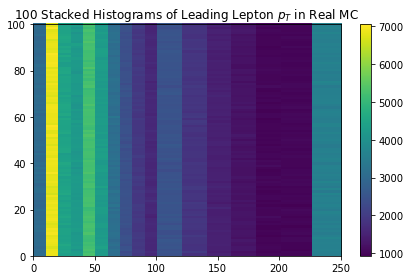

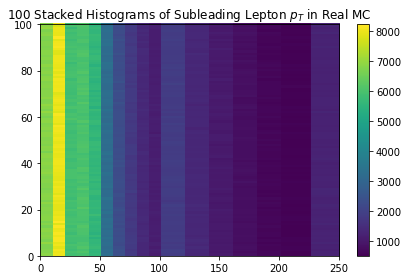

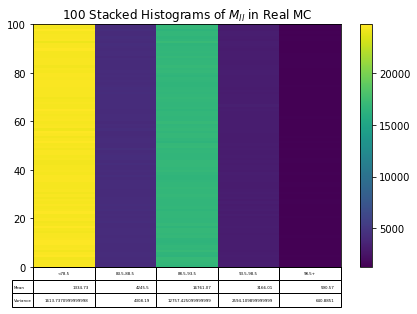

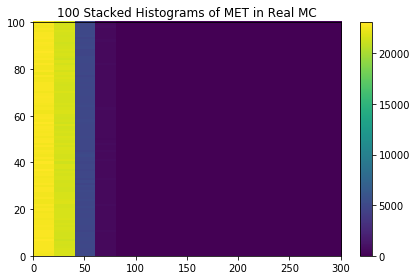

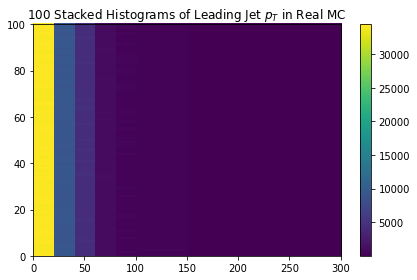

In [103]:
## Maurizo sqrt(N) checking.

ntests = 100
ybins=np.repeat(range(0,ntests+1), 1)

trial = 38
epoch=42500
input_directory = "/nfs-7/userdata/bhashemi/DY-GAN/models/progress"
tag = "v%d_batch512_bgbd_mllANDwidth_NonTC_newdata_mllfix_batchrun" % trial

#Old file with Gen/Reco mix
#input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/data_Nov10.npa"
#New Files with Gen and Reco split
input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa"
output_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/"

print("hi")

data = load_data(input_file)
#loss_type = "force_mll",
loss_type = "force_z_width"
loss_weight = 0.01

#noise_shape = (8,)
noise_shape = (19,)

print("hello")
l1e_real = []   #0
l2e_real = []   #4
mll_real = []   #computed
met_real = []   #12
j1pt_real  = []  #14
#nbin_l1iso_real = [] #10

l1e_gen = []
l2e_gen = []
mll_gen = []
met_gen = []
j1pt_gen  = []

bins_l1e = [0.0,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200,225,250]
bins_l2e = [0,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200,225,250]
#bins_mll = [0,10,20,30,40,50,60,70,80,90,100]
bins_mll = [78.5,83.5,88.5,93.5,98.5,103.5]
bins_met = [0,20,40,60,80,100,150,200,300]
bins_j1pt = [0,20,40,60,80,100,150,200,250,300]

#h_l1e_gen = np.histogram(bins_l1e)
#h_l2e_gen = []
h_mll_gen = []
#h_met_gen = []
#h_j1pt_gen  = []

real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
for i in xrange(0,ntests):
    idx = np.random.randint(0, real.shape[0], 50000)
    real = real_events[idx]
    mll_real.append(Minv(real,ptetaphi=False,nopy2=True))
    h_mll_gen.append(np.histogram(mll_real[-1], bins_mll)[0])
    l1e_real.append(real[:,0])
    l2e_real.append(real[:,4])
    met_real.append(real[:,12])
    j1pt_real.append(real[:,14])

l1e_real=np.array(l1e_real)
ys=np.repeat(np.arange(l1e_real.shape[0]),l1e_real.shape[1])
xs=np.clip(l1e_real.flatten(), bins_l1e[0], bins_l1e[-1])
fig_real_l1e, axs_real_l1e = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_real_l1e.hist2d(x=xs,y=ys, bins=[bins_l1e, ybins])
axs_real_l1e.set_title(r'%d Stacked Histograms of Leading Lepton $p_T$ in Real MC' % ntests)
plt.colorbar(r[3], ax=axs_real_l1e)
#for i in xrange(0,ntests): axs_real_l1e.axhline(i, color="black")

l2e_real=np.array(l2e_real)
ys=np.repeat(np.arange(l2e_real.shape[0]),l2e_real.shape[1])
xs=np.clip(l2e_real.flatten(), bins_l2e[0], bins_l2e[-1])
fig_real_l2e, axs_real_l2e = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_real_l2e.hist2d(x=xs,y=ys, bins=[bins_l2e, ybins])
axs_real_l2e.set_title(r'%d Stacked Histograms of Subleading Lepton $p_T$ in Real MC' % ntests)
plt.colorbar(r[3], ax=axs_real_l2e)
#for i in xrange(0,ntests): axs_real_l2e.axhline(i, color="black")

mll_real=np.array(mll_real)
ys=np.repeat(np.arange(mll_real.shape[0]),mll_real.shape[1])
xs=np.clip(mll_real.flatten(), bins_mll[0], bins_mll[-1])
fig_real_mll, axs_real_mll = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_real_mll.hist2d(x=xs,y=ys, bins=[bins_mll, ybins])
axs_real_mll.set_title(r'%d Stacked Histograms of $M_{ll}$ in Real MC' % ntests)
plt.colorbar(r[3], ax=axs_real_mll)
#for i in xrange(0,ntests): axs_real_mll.axhline(i, color="black")
h_mll_gen = np.array(h_mll_gen)
cell_text = [h_mll_gen.mean(axis=0), h_mll_gen.var(axis=0)]
row_labels = ["Mean", "Variance"]
col_labels = ["<78.5", "83.5-88.5", "88.5-93.5","93.5-98.5", "98.5+"]
axs_real_mll.table(cellText=cell_text,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='bottom')
plt.xticks([])
plt.subplots_adjust(left=0.4, bottom=0.4)
print(h_mll_gen.mean(axis=0))
print(h_mll_gen.var(axis=0))


met_real=np.array(met_real)
ys=np.repeat(np.arange(met_real.shape[0]),met_real.shape[1])
xs=np.clip(met_real.flatten(), bins_met[0], bins_met[-1])
fig_real_met, axs_real_met = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_real_met.hist2d(x=xs,y=ys, bins=[bins_met, ybins])
axs_real_met.set_title(r'%d Stacked Histograms of MET in Real MC' % ntests)
plt.colorbar(r[3], ax=axs_real_met)
#for i in xrange(0,ntests): axs_real_met.axhline(i, color="black")

j1pt_real=np.array(j1pt_real)
ys=np.repeat(np.arange(j1pt_real.shape[0]),j1pt_real.shape[1])
xs=np.clip(j1pt_real.flatten(), bins_j1pt[0], bins_j1pt[-1])
fig_real_j1pt, axs_real_j1pt = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_real_j1pt.hist2d(x=xs,y=ys, bins=[bins_j1pt, ybins])
axs_real_j1pt.set_title(r'%d Stacked Histograms of Leading Jet $p_T$ in Real MC' % ntests)
plt.colorbar(r[3], ax=axs_real_j1pt)
#for i in xrange(0,ntests): axs_real_j1pt.axhline(i, color="black")


return

model = load_model("%s/%s/gen_%d.weights" % (input_directory, tag,epoch), custom_objects={'loss_func': custom_loss(c=loss_weight, loss_type=loss_type)})
for i in xrange(0,ntests):
    real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
    preds = model.predict(noise)
    if (not i % 10): print(i)
    mll_gen.append(Minv(preds,ptetaphi=False,nopy2=True))
    l1e_gen.append(preds[:,0])
    l2e_gen.append(preds[:,4])
    met_gen.append(preds[:,12])
    j1pt_gen.append(preds[:,14])

l1e_gen=np.array(l1e_gen)
ys=np.repeat(np.arange(l1e_gen.shape[0]),l1e_gen.shape[1])
xs=np.clip(l1e_gen.flatten(), bins_l1e[0], bins_l1e[-1])
fig_gen_l1e, axs_gen_l1e = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_gen_l1e.hist2d(x=xs,y=ys, bins=[bins_l1e, ybins])
axs_gen_l1e.set_title(r'%d Stacked Histograms of Leading Lepton $p_T$ from Generator' % ntests)
plt.colorbar(r[3], ax=axs_gen_l1e)
#for i in xrange(0,ntests): axs_gen_l1e.axhline(i, color="black")

l2e_gen=np.array(l2e_gen)
ys=np.repeat(np.arange(l2e_gen.shape[0]),l2e_gen.shape[1])
xs=np.clip(l2e_gen.flatten(), bins_l1e[0], bins_l1e[-1])
fig_gen_l2e, axs_gen_l2e = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_gen_l2e.hist2d(x=xs,y=ys, bins=[bins_l2e, ybins])
axs_gen_l2e.set_title(r'%d Stacked Histograms of Subleading Lepton $p_T$ from Generator' % ntests)
plt.colorbar(r[3], ax=axs_gen_l2e)
#for i in xrange(0,ntests): axs_gen_l1e.axhline(i, color="black")

mll_gen=np.array(mll_gen)
ys=np.repeat(np.arange(mll_gen.shape[0]),mll_gen.shape[1])
xs=np.clip(mll_gen.flatten(), bins_mll[0], bins_mll[-1])
fig_gen_mll, axs_gen_mll = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_gen_mll.hist2d(x=xs,y=ys, bins=[bins_mll, ybins])
axs_gen_mll.set_title(r'%d Stacked Histograms of $M_{ll}$ from Generator' % ntests)
plt.colorbar(r[3], ax=axs_gen_mll)
#for i in xrange(0,ntests): axs_gen_mll.axhline(i, color="black")

met_gen=np.array(met_gen)
ys=np.repeat(np.arange(met_gen.shape[0]),met_gen.shape[1])
xs=np.clip(met_gen.flatten(), bins_met[0], bins_met[-1])
fig_gen_met, axs_gen_met = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_gen_met.hist2d(x=xs,y=ys, bins=[bins_met, ybins])
axs_gen_met.set_title(r'%d Stacked Histograms of MET from Generator' % ntests)
plt.colorbar(r[3], ax=axs_gen_met)
#for i in xrange(0,ntests): axs_gen_met.axhline(i, color="black")

j1pt_gen=np.array(j1pt_gen)
ys=np.repeat(np.arange(j1pt_gen.shape[0]),j1pt_gen.shape[1])
xs=np.clip(j1pt_gen.flatten(), bins_j1pt[0], bins_j1pt[-1])
fig_gen_j1pt, axs_gen_j1pt = plt.subplots(nrows=1, sharex=True, tight_layout=True)
r = axs_gen_j1pt.hist2d(x=xs,y=ys, bins=[bins_j1pt, ybins])
axs_gen_j1pt.set_title(r'%d Stacked Histograms of Leading Jet $p_T$ from Generator' % ntests)
plt.colorbar(r[3], ax=axs_gen_j1pt)
#for i in xrange(0,ntests): axs_gen_j1pt.axhline(i, color="black")



fig_real_l1e.savefig("variancecheck_l1e_real_long.png")
fig_real_l2e.savefig("variancecheck_l2e_real_long.png")
fig_real_mll.savefig("variancecheck_mll_real_long.png")
fig_real_met.savefig("variancecheck_met_real_long.png")
fig_real_j1pt.savefig("variancecheck_j1pt_real_long.png")

fig_gen_l1e.savefig("variancecheck_l1e_gen_long.png")
fig_gen_l2e.savefig("variancecheck_l2e_gen_long.png")
fig_gen_mll.savefig("variancecheck_mll_gen_long.png")
fig_gen_met.savefig("variancecheck_met_gen_long.png")
fig_gen_j1pt.savefig("variancecheck_j1pt_gen_long.png")



In [1]:
#This section is to show Maurizio how to interface with our results...

#I've uploaded a couple models to http://www.uaf-10.t2.ucsd.edu/~bhashemi/GAN_Share/gen_trialX_epochY.h5
#I also included the discriminators, but I don't think you'll need those.
#The delphes file in a numpy array cleaned up by nick is here: http://www.uaf-10.t2.ucsd.edu/~bhashemi/GAN_Share/total_Zmumu_13TeV_PU20_v2.npa

#Things you need to know how to do....
#1. Load in the Delphes MC Data:
input_file = "/path/to/numpy/array/total_Zmumu_13TeV_PU20_v2.npa" #replace this with where you copy the file... Keep the same filename because I do some switching based on that above...
data = load_data(input_file)
real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000) #noise will be what you pass to the generator to get output, it's just a quirk of the code that we get that now...

#2. Load in the model:
# we use a cutsom loss, so that needs to be built when we load in the model...
loss_type = "force_z_width"
loss_weight = 0.01
noise_shape = (19,)
path_to_model = "/Replace/With/Whereever/You/Store/File"
model = load_model("%s" % (path_to_model), custom_objects={'loss_func': custom_loss(c=loss_weight, loss_type=loss_type)})
preds = model.predict(noise)

#3. Know what you're plotting
# preds and real_events are the two event lists, preds are generated events and real_events are from delphes 
# Each of these are 19 column arrays, the 19 columns can be read off from the get_noise() function above... Here is a list
#Index     Variable
#0         lep1 Energy
#1         lep1 px
#2         lep1 py
#3         lep1 pz
#4         lep2 e
#5         lep2 px
#6         lep2 pz
#7         nvtx Count Smeared With Gaussian
#8         lep1 charge
#9         lep2 charge
#10        lep1 isolation 
#11        lep2 isolation
#12        met
#13        metphi
#14        jet1 pt
#15        jet2 pt
#16        jet3 pt
#17        jet4 pt
#18        jet5 pt




NameError: name 'load_data' is not defined

('genjet_pt1', 'genjet_pt2', 'genjet_pt3', 'genjet_pt4', 'genjet_pt5', 'genlep1_charge', 'genlep1_e', 'genlep1_iso', 'genlep1_px', 'genlep1_py', 'genlep1_pz', 'genlep2_charge', 'genlep2_e', 'genlep2_iso', 'genlep2_px', 'genlep2_pz', 'genmet', 'genmetphi', 'genmll', 'jet_pt1', 'jet_pt2', 'jet_pt3', 'jet_pt4', 'jet_pt5', 'lep1_charge', 'lep1_e', 'lep1_iso', 'lep1_px', 'lep1_py', 'lep1_pz', 'lep2_charge', 'lep2_e', 'lep2_iso', 'lep2_px', 'lep2_pz', 'met', 'metphi', 'mll', 'nvtxs')


IndexError: index 17 is out of bounds for axis 1 with size 17

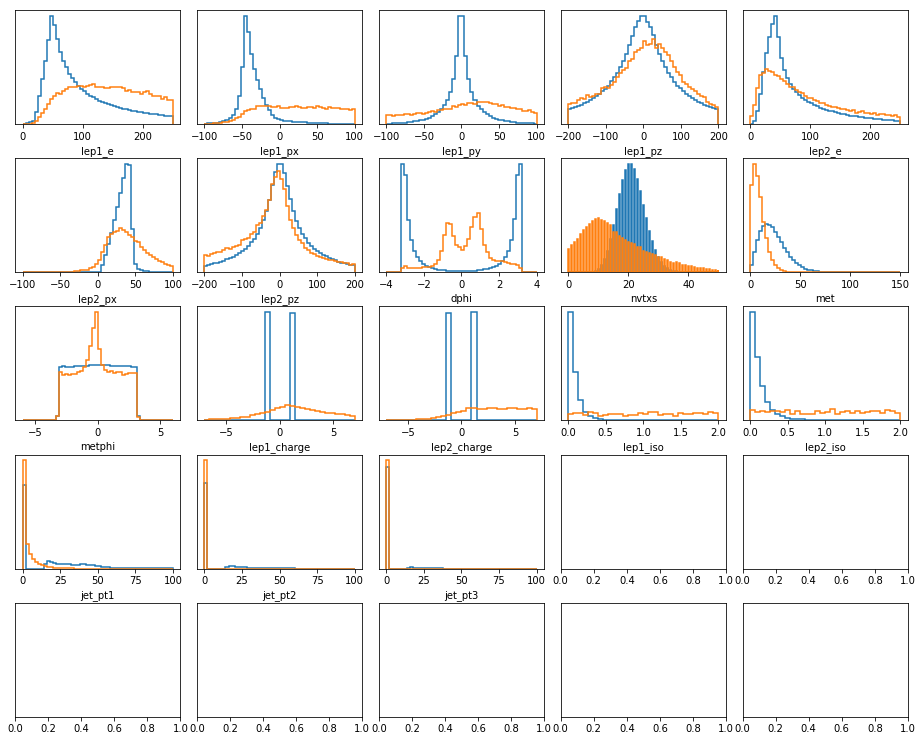

In [10]:
#Remake Plots:
#epoch = 42500
#trial = 38

epoch = 60900
trial = 22

#tag = "v%d_batch512_bgbd_mllANDwidth_NonTC_newdata_mllfix_batchrun" % trial
#model_dir = "/nfs-7/userdata/bhashemi/DY-GAN/models/progress/"

tag = "jetisoscaleRobust_mllwidth_flatNegNoise_%i" % trial
model_dir = "/home/users/bhashemi/Projects/GIT/DY-GAN/gan/notebooks/progress/"


model_loc = model_dir+"%s/gen_%d.weights" % (tag,epoch)


#Old file with Gen/Reco mix
#input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/data_Nov10.npa"
#New Files with Gen and Reco split
input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa"

data = load_data(input_file)
print(data.dtype.names)
#loss_type = "force_mll",
loss_type = "force_z_width"
loss_weight = 0.01

#noise_shape = (8,)
noise_shape = (17,)

model = load_model(model_loc, custom_objects={'loss_func': custom_loss(c=loss_weight, loss_type=loss_type)})
real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)
real = real_events[:50000]
preds = model.predict(noise)
make_plots_new(preds,data,title="Trial %d Epoch %d" % (trial, epoch),fname="bestmodel_12_54000.png",show_pred=True,wspace=0.1,hspace=0.3,tightlayout=True,visible=True)





In [29]:
#Check mll distribution after scaling:
input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa"

data = load_data(input_file)
data = data[data["genmll"] > 50.]

noise_shape = (19,)
real_events, noise_half, noise = get_noise(input_file, data, 1, noise_shape, 50000)



scaler = MinMaxScaler(feature_range=(-1.,1.))
scaler.fit(real_events)
real_events_scaled = scaler.transform(real_events).astype(np.float32)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


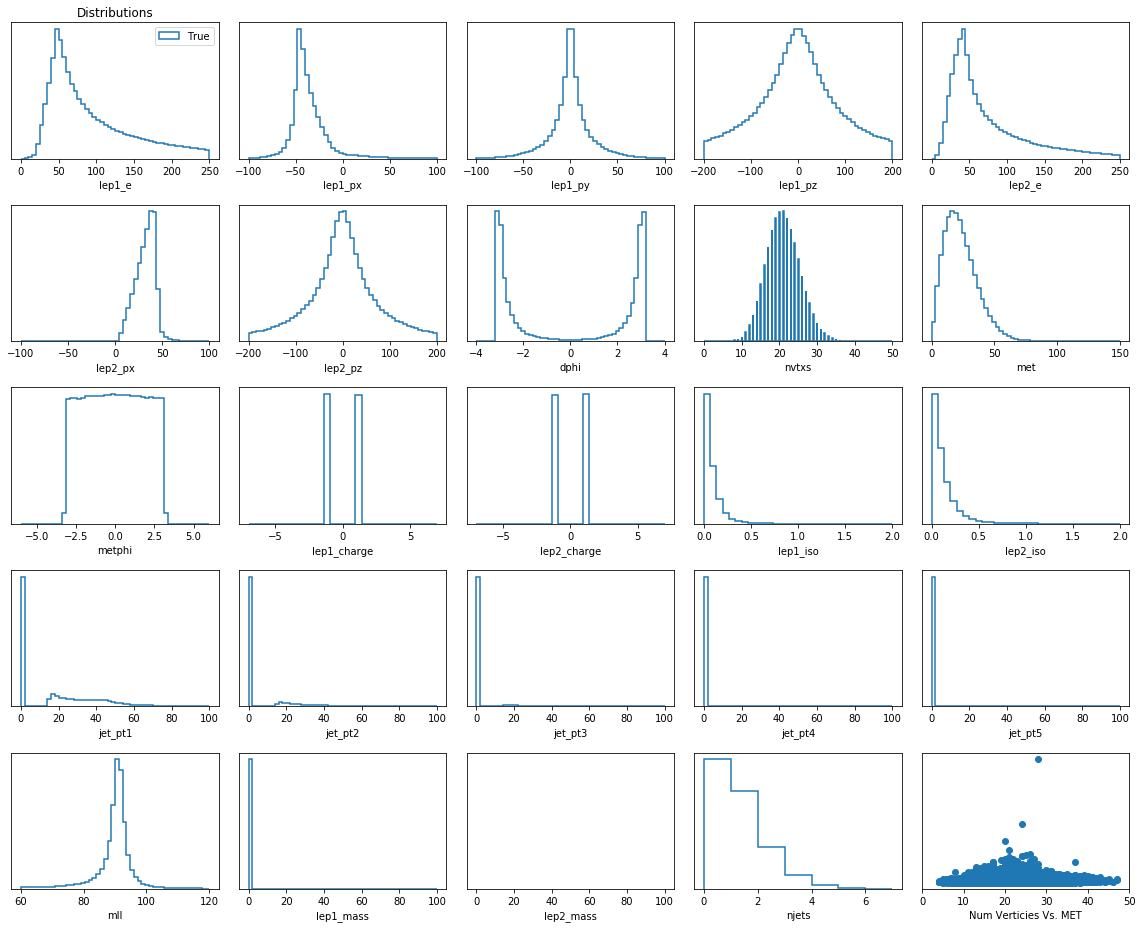

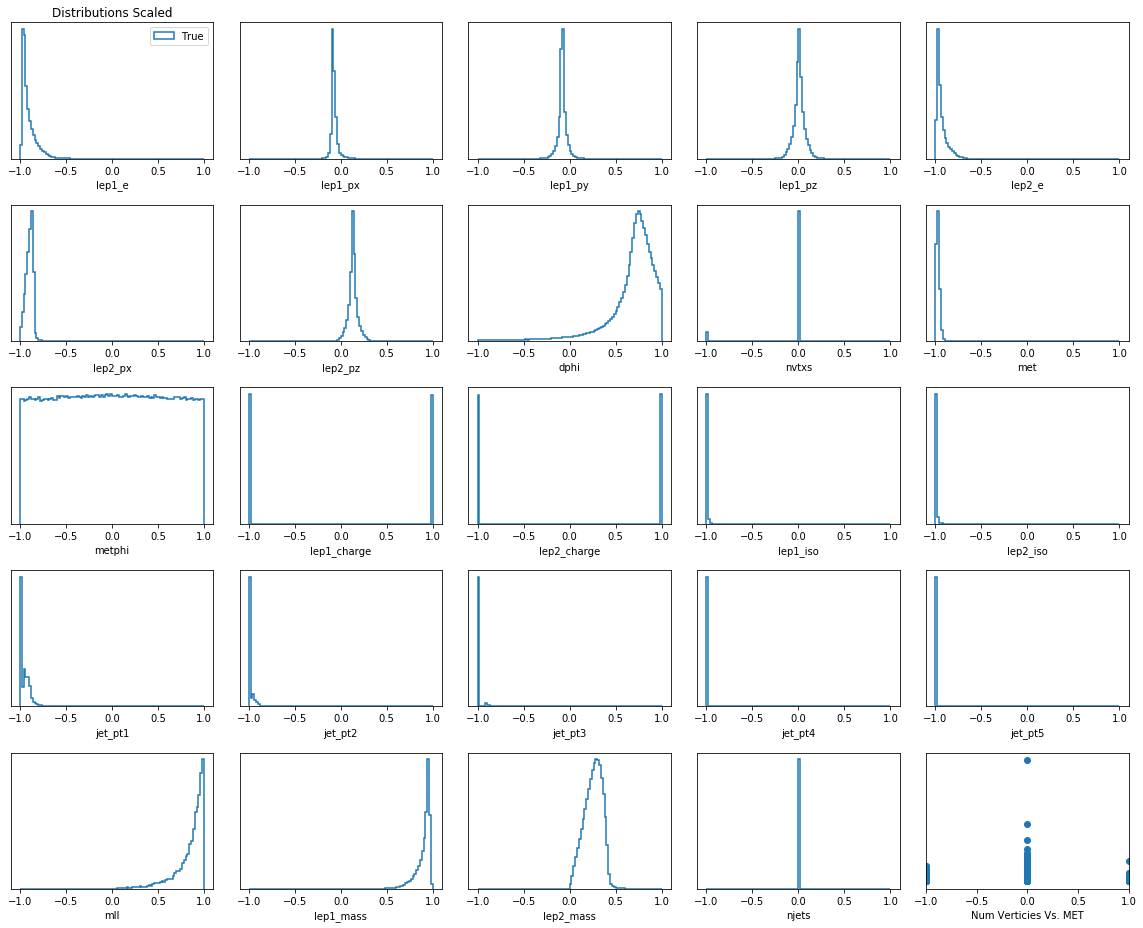

In [36]:
make_plots_new(real_events,data,title="Distributions",fname="dists.png",show_data=False,wspace=0.1,hspace=0.3,tightlayout=True,visible=True)
make_plots_new(real_events_scaled,data,title="Distributions Scaled",fname="dists_scaled.png",scaled=True,show_data=False,wspace=0.1,hspace=0.3,tightlayout=True,visible=True)


In [5]:
import pickle

ei = pickle.load( open("progress/jetisoscaleRobust_mllwidth_flatNegNoise_16/history.pkl") )

In [12]:
zip(ei["epoch"], ei["ks"], ei["d_loss"], ei["g_loss"])

[(200, 14.940066666666667, 0.47440213, 5.203441),
 (300, 13.501866666666668, 0.369085, 4.9080014),
 (400, 14.158966666666666, 0.04340058, 5.8257437),
 (500, 15.162466666666665, 0.06899819, 5.1949964),
 (600, 15.171866666666665, 0.29683596, 7.2756696),
 (700, 14.632566666666667, 0.10750353, 4.567291),
 (800, 14.308900000000001, 0.015140213, 6.283003),
 (900, 14.401800000000001, 0.06689568, 5.1768727),
 (1000, 14.708833333333335, 0.102234125, 9.083889),
 (1100, 14.549900000000001, 0.078792244, 5.1542764),
 (1200, 14.117166666666668, 0.0783644, 5.9928474),
 (1300, 14.437500000000002, 7.9834275, 0.0056775287),
 (1400, 14.849433333333335, 7.9825835, 0.010977946),
 (1500, 14.866133333333332, 7.9793506, 0.006971836),
 (1600, 14.943700000000002, 7.97799, 0.006436697),
 (1700, 14.8709, 8.062768, 0.0054468745),
 (1800, 14.853399999999999, 7.978633, 0.0052634254),
 (1900, 14.753200000000001, 7.9794965, 0.0041698366),
 (2000, 14.687033333333334, 7.980269, 0.003915463),
 (2100, 14.692533333333335, 

In [55]:
#epoch_info = pickle.load( open("{}/progress/{}/history.pkl".format(self.outdir,self.tag)) )
metrics = ["ks", "g_loss"]
trial_info = []
for i in xrange(14,18):
    trial_log = pickle.load( open("progress/jetisoscaleRobust_mllwidth_flatNegNoise_%d/history.pkl" % i) )
    a = [{"ks": x[0], "g_loss" : x[1]} for x in zip(trial_log["ks"], trial_log["g_loss"])]
    trial_info += zip(np.zeros(len(trial_log["epoch"]))+i, trial_log["epoch"], a)

#print trial_info   
    
sorted_trials = {}

#Get dict of epoch lists, each list is sorted by the metric 'm'
for m in metrics:
    sorted_trials[m] = list(enumerate(np.array(sorted(trial_info, key = lambda x: x[2][m]))[:,0:2]))

#print sorted_trials["g_loss"]

epoch_score = {}
for row in sorted_trials[metrics[0]]:
    epoch_score["%d_%d" % (row[1][0], row[1][1])] = [row[0], {metrics[0]: row[0]}]

for m in metrics[1:]:
    for row in sorted_trials[m]:
        epoch_score["%d_%d" % (row[1][0], row[1][1])][0] += row[0]
        epoch_score["%d_%d" % (row[1][0], row[1][1])][1][m] = row[0]

sorted(epoch_score.items(), key=lambda k: k[1][0])

[('17_42100', [901, {'g_loss': 895, 'ks': 6}]),
 ('17_38000', [917, {'g_loss': 916, 'ks': 1}]),
 ('17_30100', [930, {'g_loss': 928, 'ks': 2}]),
 ('17_37000', [936, {'g_loss': 891, 'ks': 45}]),
 ('17_37600', [939, {'g_loss': 918, 'ks': 21}]),
 ('17_37500', [953, {'g_loss': 929, 'ks': 24}]),
 ('17_42200', [959, {'g_loss': 907, 'ks': 52}]),
 ('17_37700', [971, {'g_loss': 948, 'ks': 23}]),
 ('17_39700', [973, {'g_loss': 961, 'ks': 12}]),
 ('17_40600', [975, {'g_loss': 890, 'ks': 85}]),
 ('17_40900', [982, {'g_loss': 982, 'ks': 0}]),
 ('17_48300', [987, {'g_loss': 924, 'ks': 63}]),
 ('17_40500', [988, {'g_loss': 923, 'ks': 65}]),
 ('15_34400', [1001, {'g_loss': 12, 'ks': 989}]),
 ('17_37900', [1002, {'g_loss': 943, 'ks': 59}]),
 ('17_29100', [1004, {'g_loss': 932, 'ks': 72}]),
 ('17_38500', [1006, {'g_loss': 917, 'ks': 89}]),
 ('17_41000', [1006, {'g_loss': 988, 'ks': 18}]),
 ('17_36100', [1007, {'g_loss': 1000, 'ks': 7}]),
 ('17_35900', [1008, {'g_loss': 967, 'ks': 41}]),
 ('17_28400', [10

In [10]:
input_file = "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa"

data = load_data(input_file)
data = data[data["genmll"] > 50.]

In [11]:
def M4(E,px,py,pz):
    return np.sqrt(E*E - px*px - py*py - pz*pz)

print np.mean(data["mll"])
print np.std(data["mll"])
lep1m = M4(data["lep1_e"], data["lep1_px"], data["lep1_py"], data["lep1_pz"])
lep2m = M4(data["lep2_e"], data["lep2_px"], 0, data["lep2_pz"])
#lep2m = np.sqrt(data["lep2_e"]**2 - data["lep2_px"]**2 - data["lep2_pz"]**2)
print np.nanmean(lep1m*lep1m)
print np.nanstd(lep1m*lep1m)
print np.nanmean(lep2m*lep2m)
print np.nanstd(lep2m*lep2m)

89.433395
11.899904
0.011312853
0.004086783
0.011166358
0.0016794492


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
